In [1]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

FileNotFoundError: [Errno 2] No such file or directory: './content'

/tmp/ipykernel_25932/2529335328.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


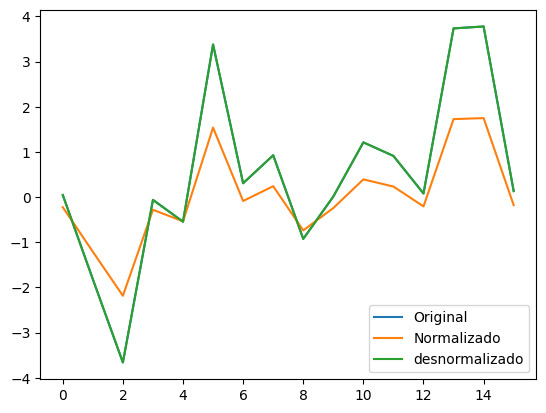

StandardScaler()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()
input_scaler = StandardScaler()

def peaks(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return x, y, z

def create_dataframe(grid):
   x, y, z = peaks(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

def show_norm(df, label="Peaks", plot=False):
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)

def test_out_scaler(df):
    out = df["Z"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    denorm = out_scaler.inverse_transform(norm)
    plt.plot(denorm, label='desnormalizado')
    plt.legend()
    plt.show()

def split_df(df):
    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

df_25 = create_dataframe(grid=4)
df_25_norm = show_norm(df_25)
test_out_scaler(df_25)

df_1000 = create_dataframe(grid=32)
df_1000_norm = show_norm(df_1000)

_input, _output = split_df(df_25)
input_scaler.fit(_input)

In [ ]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-04 23:05:05.971706: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 23:05:05.971756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 23:05:05.972794: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 23:05:05.979032: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 23:05:06.868418: W tensorflow/compiler/tf2

ModuleNotFoundError: No module named 'levenberg_marquardt'

In [ ]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 
import plotly.figure_factory as ff
import plotly.offline as py
from scipy.spatial import Delaunay
import plotly.graph_objs as go


class Rebuild:
    def __init__(self):
        self.df = pd.read_excel(f"../../better_results_03.xlsx")        
        self.sup_input, self.sup_output = split_df(df_1000_norm)

    def LoadModelWeights(self, model, fileName):        
        path = f"../models/{fileName}.keras"
        model.load_weights(path)

    def LoadPrevDataset(self, fileName):
        fileName = fileName.replace("model", "dataset")
        pos = fileName.rfind("_")
        path = f"../dataset/{fileName[:pos]}.pkl" 
        with open(path, 'rb') as f:
            _data, _train, _vt, _val, _test = pickle.load(f)
        self._data, self._train, self._vt, self._val, self._test = _data, _train, _vt, _val, _test    
    
    def setArchitecture(self, _hidden_sizes, _pg, _lr):
        shuffler = ShuffleArchitecture(input_size = 2,
                                    hidden_sizes = _hidden_sizes,
                                    output_size = 1,
                                    act_h = 'tanh',
                                    act_o = 'linear',
                                    param_reg = _pg)
        shuffler.set_architecture()
        self.k = shuffler.compute_k()
        return(shuffler.create_model(_lr))            

    def getArchitecture(self, architecture):
        hidden_size = [int(x) for x in architecture.split("[")[1].split("]")[0].split(", ")]
        regularizer = float(architecture.split("regularizer=")[1].split(",")[0])
        learning_rate = float(architecture.split("learning_rate=")[1])
        return hidden_size, regularizer, learning_rate

    def PlotResults(self, original_values, predicted_values):
        titles = ['Original vs. Preditos (Completo)',
                    'Original vs. Preditos (Teste)',
                    'Original vs. Preditos (Validação)',
                    'Original vs. Preditos (Validação e Teste)']
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        for i, ax in enumerate(axes.flat):
            ax.plot(original_values[i], label='Original')
            ax.plot(predicted_values[i], label='Preditos')
            ax.set_title(titles[i])
            ax.legend()
        plt.tight_layout()
        plt.show()


    def PlotSurface(self, original_values, predicted_values, model):
        x, y, z = df_1000['X'], df_1000['Y'], df_1000['Z']
        points = np.column_stack((x, y))
        tri = Delaunay(points)
        
        fig_original = ff.create_trisurf(x=x, y=y, z=original_values.flatten(), 
                                        simplices=tri.simplices, colormap='Greys',
                                        title='Surface Fit - Original Values')

        fig_predicted = ff.create_trisurf(x=x, y=y, z=predicted_values.flatten(), 
                                        simplices=tri.simplices, colormap='Viridis',
                                        title='Surface Fit - Predicted Values')

        data = [fig_original.data[0], fig_predicted.data[0], ]
        fig = go.Figure(data=data)
        fig.update_layout(title='Surface Fit', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
        fig.show()

    def print_MSE(self, original_values, predicted_values):
        MSE_sup= mean_squared_error(original_values,predicted_values)
        mse_sup = f"\nMSE de superficie: {MSE_sup}\n"
        return mse_sup


    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)

    def RecalcMetrics(self, idx,
                        out_denorm, test_denorm, val_denorm, vt_denorm, sup_denorm,
                        pred_denorm, test_pred_denorm, val_pred_denorm, vt_pred_denorm, sup_pred_denorm):
        r2 = r2_score(out_denorm, pred_denorm)
        r2_test = r2_score(test_denorm, test_pred_denorm)
        r2_val = r2_score(val_denorm, val_pred_denorm)
        r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
        r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

        mse = mean_squared_error(out_denorm, pred_denorm)
        mse_test = mean_squared_error(test_denorm, test_pred_denorm)
        mse_val = mean_squared_error(val_denorm, val_pred_denorm)
        mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
        mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
        
        mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
        self.df.loc[idx, 'r2'] = r2
        self.df.loc[idx, 'r2_sup'] = r2_sup
        self.df.loc[idx, 'r2_test'] = r2_test
        self.df.loc[idx, 'r2_val'] = r2_val
        self.df.loc[idx, 'r2_vt'] = r2_vt
        self.df.loc[idx, 'mse'] = mse
        self.df.loc[idx, 'mse_sup'] = mse_sup
        self.df.loc[idx, 'mse_test'] = mse_test
        self.df.loc[idx, 'mse_val'] = mse_val
        self.df.loc[idx, 'mse_vt'] = mse_vt
        self.df.loc[idx, 'mape'] = mape
        self.df.loc[idx, 'rmse'] = rmse
        self.df.loc[idx, 'r2_adj'] = r2_adj
        self.df.loc[idx, 'rsd'] = rsd
        self.df.loc[idx, 'aic'] = aic
        self.df.loc[idx, 'bic'] = bic

    
    def GetOuts(self, df, out_denorm, pred_denorm, fileName):
        input, output = split_df(df)
        
        data = {'X': input[:, 0].flatten(),
                'Y': input[:, 0].flatten(),
                'Z': out_denorm.flatten(),
                'Z_pred': pred_denorm.flatten()}
        
        df = pd.DataFrame(data)
        df.to_excel(f"../../{fileName}.xlsx", index=False)


    def predictResults(self, idx=-1):
        pred = self.lm_model.predict(self._data[0]).flatten()
        test_pred = self.lm_model.predict(self._test[0]).flatten()
        val_pred = self.lm_model.predict(self._val[0]).flatten()
        vt_pred = self.lm_model.predict(self._vt[0]).flatten()
        sup_pred = self.lm_model.predict(self.sup_input).flatten()

        # Calculando as metricas com a saida desnormalizada
        pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
        test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
        val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
        vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
        sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

        out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
        test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
        val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
        vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))
        sup_denorm = out_scaler.inverse_transform(self.sup_output.reshape(-1, 1))

        original_values = [out_denorm, test_denorm, val_denorm, vt_denorm, sup_denorm]
        predicted_values = [pred_denorm, test_pred_denorm, val_pred_denorm, vt_pred_denorm, sup_pred_denorm]

        if (idx != -1):
            self.RecalcMetrics(idx,
                                out_denorm, test_denorm, val_denorm, vt_denorm, sup_denorm,
                                pred_denorm, test_pred_denorm, val_pred_denorm, vt_pred_denorm, sup_pred_denorm)            
        return (original_values, predicted_values)


    def rebuildFullNet(self, model):
        for file_model, architecture in zip(self.df["model"], self.df["Architecture"]):
            if model == file_model:
                hidden_size, regularizer, learning_rate = self.getArchitecture(architecture)
                self.lm_model = self.setArchitecture(hidden_size, regularizer, learning_rate)
                self.LoadPrevDataset(file_model)
                original_values, predicted_values = self.predictResults()
                self.PlotSurface(original_values[4], predicted_values[4], model)
                self.GetOuts(df_25, original_values[0], predicted_values[0], f"25_{model}")
                self.GetOuts(df_1000, original_values[4], predicted_values[4], f"1000_{model}")
                mse_pred=self.print_MSE(original_values[4], predicted_values[4])
                print(f" {mse_pred}")
                


In [ ]:
Rebuilder = Rebuild()
Rebuilder.rebuildFullNet("model_8_8_19")

32/32 [==============================] - 0s 2ms/step


ValueError: All arrays must be of the same length

In [ ]:
Rebuilder = Rebuild()
Rebuilder.rebuildFullNet("model_52_9_6")

32/32 [==============================] - 0s 3ms/step


 
MSE de superficie: 15.095679259669447



In [ ]:
Rebuilder = Rebuild()
Rebuilder.rebuildFullNet("model_38_9_24")

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/dataset_38_9.pkl'

In [ ]:
Rebuilder = Rebuild()
Rebuilder.rebuildFullNet("model_52_9_12")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../models/model_52_9_12.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)